In [ ]:
!pip install requests

In [ ]:
import requests

def get_weather_data(location):
    # Replace with actual API call to get weather data
    api_key = "8492e9c924db4c5aa7130051240611"  # Your provided API key
    response = requests.get(f"https://api.weatherapi.com/v1/current.json?key={api_key}&q={location}")

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching weather data: Status code {response.status_code}")
        print(response.text)  # Print the error response for debugging
        return {}  # Return an empty dictionary to avoid further errors

def calculate_energy_needs(ev_efficiency_kwh_per_mile, daily_miles):
    return ev_efficiency_kwh_per_mile * daily_miles

def calculate_solar_output(panel_wattage, peak_sun_hours, weather_factor):
    # Adjust output based on weather conditions (0 to 1 scale)
    adjusted_output = panel_wattage * peak_sun_hours * weather_factor
    return adjusted_output / 1000  # Convert to kWh

def predict_charge_percentage(ev_battery_capacity_kwh, energy_needs, solar_output):
    total_energy_available = min(energy_needs, solar_output)
    return (total_energy_available / ev_battery_capacity_kwh) * 100

# User-defined parameters
location = "Delhi"
ev_efficiency_kwh_per_mile = 0.24  # Example for a typical EV
daily_miles = 50 # Average miles driven per day
ev_battery_capacity_kwh = 40.02# Example battery capacity
panel_wattage = 300  # Example solar panel wattage
peak_sun_hours = 5  # Average peak sun hours per day

# Get weather data
weather_data = get_weather_data(location)
# Check if weather_data is empty due to an error
if weather_data:
    weather_factor = 0.8 if weather_data['current']['condition']['text'] == 'Sunny' else 0.5
else:
    weather_factor = 0.5  # Default to 0.5 if weather data is unavailable

# Calculate energy needs and solar output
energy_needs = calculate_energy_needs(ev_efficiency_kwh_per_mile, daily_miles)
solar_output = calculate_solar_output(panel_wattage, peak_sun_hours, weather_factor)

# Predict charge percentage
charge_percentage = predict_charge_percentage(ev_battery_capacity_kwh, energy_needs, solar_output)

print(f"The EV can be charged by {charge_percentage:.2f}% using solar power today.")

The EV can be charged by 1.87% using solar power today.


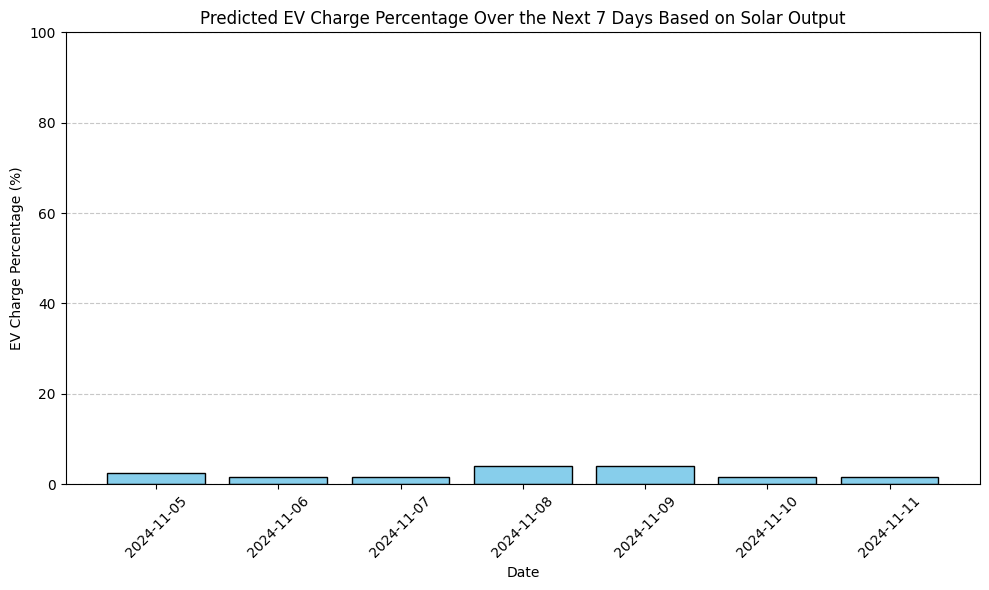

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def get_weather_data(location, days=7):
    api_key = "8492e9c924db4c5aa7130051240611"  # Your provided API key
    response = requests.get(f"https://api.weatherapi.com/v1/forecast.json?key={api_key}&q={location}&days={days}")

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching weather data: Status code {response.status_code}")
        print(response.text)
        return {}

def calculate_energy_needs(ev_efficiency_kwh_per_mile, daily_miles):
    return ev_efficiency_kwh_per_mile * daily_miles

def calculate_solar_output(panel_wattage, peak_sun_hours, weather_factor):
    adjusted_output = panel_wattage * peak_sun_hours * weather_factor
    return adjusted_output / 1000  # Convert to kWh

def predict_charge_percentage(ev_battery_capacity_kwh, energy_needs, solar_output):
    total_energy_available = min(energy_needs, solar_output)
    return (total_energy_available / ev_battery_capacity_kwh) * 100

# User-defined parameters
location = "Delhi"
ev_efficiency_kwh_per_mile = 0.24
daily_miles = 50
ev_battery_capacity_kwh = 30.02
panel_wattage = 300
peak_sun_hours = 5

# Get 7-day weather forecast data
weather_data = get_weather_data(location, days=7)

# Lists to store daily data for plotting
dates = []
charge_percentages = []

# Process each day in the weather forecast
if 'forecast' in weather_data:
    for day in weather_data['forecast']['forecastday']:
        date = day['date']
        condition = day['day']['condition']['text']
        dates.append(date)

        # Set weather factor based on the condition
        if 'Sunny' in condition:
            weather_factor = 0.8
        elif 'Cloudy' in condition:
            weather_factor = 0.5
        else:
            weather_factor = 0.3

        # Calculate energy needs and solar output for the day
        energy_needs = calculate_energy_needs(ev_efficiency_kwh_per_mile, daily_miles)
        solar_output = calculate_solar_output(panel_wattage, peak_sun_hours, weather_factor)

        # Calculate and store the charge percentage
        charge_percentage = predict_charge_percentage(ev_battery_capacity_kwh, energy_needs, solar_output)
        charge_percentages.append(charge_percentage)

# Plotting the EV charge percentages for each day
plt.figure(figsize=(10, 6))
plt.bar(dates, charge_percentages, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('EV Charge Percentage (%)')
plt.title('Predicted EV Charge Percentage Over the Next 7 Days Based on Solar Output')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set limit to 100% for easy comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install requests prophet
# %%
import requests
import pandas as pd
from prophet import Prophet

def get_weather_data(location):
    """
    Fetches current weather data for a given location using the WeatherAPI.

    Args:
        location (str): The location for which to fetch weather data.

    Returns:
        dict: A dictionary containing the weather data if the request is successful,
              an empty dictionary otherwise.
    """
    api_key = "8492e9c924db4c5aa7130051240611"  # Your provided API key
    response = requests.get(f"https://api.weatherapi.com/v1/current.json?key={api_key}&q={location}")

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching weather data: Status code {response.status_code}")
        print(response.text)  # Print the error response for debugging
        return {}  # Return an empty dictionary to avoid further errors

def calculate_energy_needs(ev_efficiency_kwh_per_mile, daily_miles):
    """
    Calculates the daily energy needs of an EV based on efficiency and miles driven.

    Args:
        ev_efficiency_kwh_per_mile (float): The EV's efficiency in kWh per mile.
        daily_miles (int): The average daily miles driven.

    Returns:
        float: The total daily energy needs in kWh.
    """
    return ev_efficiency_kwh_per_mile * daily_miles

def calculate_solar_output(panel_wattage, peak_sun_hours, weather_factor):
    """
    Calculates the estimated solar output based on panel wattage, sun hours, and weather.

    Args:
        panel_wattage (int): The total wattage of the solar panels.
        peak_sun_hours (int): The average peak sun hours per day.
        weather_factor (float): A factor between 0 and 1 representing weather conditions.

    Returns:
        float: The estimated solar output in kWh.
    """
    adjusted_output = panel_wattage * peak_sun_hours * weather_factor
    return adjusted_output / 1000  # Convert to kWh

def predict_charge_percentage(ev_battery_capacity_kwh, energy_needs, solar_output):
    """
    Predicts the charge percentage of an EV based on energy needs and solar output.

    Args:
        ev_battery_capacity_kwh (float): The EV's battery capacity in kWh.
        energy_needs (float): The EV's daily energy needs in kWh.
        solar_output (float): The estimated solar output in kWh.

    Returns:
        float: The predicted charge percentage.
    """
    total_energy_available = min(energy_needs, solar_output)
    return (total_energy_available / ev_battery_capacity_kwh) * 100

# User-defined parameters
location = "Delhi"
ev_efficiency_kwh_per_mile = 0.24  # Example for a typical EV
daily_miles = 50 # Average miles driven per day
ev_battery_capacity_kwh = 30.02# Example battery capacity
panel_wattage = 300  # Example solar panel wattage

# --- Time Series Analysis ---
# Load historical solar output data (replace with your actual data)
# solar_data = pd.read_csv("solar_data.csv", parse_dates=['ds'])
# Assume 'ds' column is datetime and 'y' column is solar output in kWh
solar_data = pd.DataFrame({
    'ds': pd.to_datetime(['2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05']),
    'y': [1.2, 1.5, 1.3, 1.4, 1.6]  # Example solar output values
})

# Create and fit the Prophet model
model = Prophet()
model.fit(solar_data)

# Make future predictions for today
# Modified to predict

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb385u8zd/9qqjrtey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb385u8zd/so45j1zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12750', 'data', 'file=/tmp/tmpb385u8zd/9qqjrtey.json', 'init=/tmp/tmpb385u8zd/so45j1zh.json', 'output', 'file=/tmp/tmpb385u8zd/prophet_model1kqg2liv/prophet_model-20241106032041.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:20:41 - cmdstanpy - INFO - Chain [1] start processing
IN